In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, fsolve
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [2]:
swaption = pd.read_excel ('IR Data.xlsx', sheet_name='Swaption', skiprows = 2, header = 0)
swaption = swaption.iloc[0:15,0:13]
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100
swap = swaption.set_index(['Expiry', 'Tenor'])
swap 

-200bps  -150bps  -100bps   -50bps   -25bps     ATM  +25bps  \
Expiry Tenor                                                                
1Y     1Y     0.91570  0.62030  0.44130  0.31224  0.26182  0.2250  0.2096   
       2Y     0.83270  0.61240  0.46570  0.35807  0.31712  0.2872  0.2712   
       3Y     0.73920  0.56870  0.44770  0.35745  0.32317  0.2978  0.2829   
       5Y     0.55190  0.44640  0.36510  0.30242  0.27851  0.2607  0.2498   
       10Y    0.41180  0.35040  0.30207  0.26619  0.25351  0.2447  0.2398   
5Y     1Y     0.67800  0.49090  0.38400  0.31485  0.29060  0.2726  0.2604   
       2Y     0.57880  0.46410  0.39033  0.33653  0.31531  0.2983  0.2856   
       3Y     0.53430  0.44440  0.38180  0.33437  0.31536  0.2998  0.2876   
       5Y     0.41990  0.36524  0.32326  0.29005  0.27677  0.2660  0.2573   
       10Y    0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399   
10Y    1Y     0.55160  0.44320  0.37368  0.32259  0.30210  0.2854  0.2731   
       2Y     0.51170  0.42900  0.37078  0.32622  0.30800  0.2928  0.2809   
       3Y     0.48220  0.41430  0.36400  0.32439  0.30796  0.2940  0.2827   
       5Y     0.40550  0.35891  0.32181  0.29144  0.27857  0.2674  0.2580   
       10Y    0.33601  0.30509  0.27978  0.25926  0.25086  0.2437  0.2376   

              +50bps  +100bps  +150bps  +200bps  
Expiry Tenor                                     
1Y     1Y     0.2140   0.2434  0.27488  0.30297  
       2Y     0.2684   0.2851  0.31025  0.33523  
       3Y     0.2780   0.2877  0.30725  0.32833  
       5Y     0.2456   0.2512  0.26536  0.28165  
       10Y    0.2382   0.2425  0.25204  0.26355  
5Y     1Y     0.2532   0.2494  0.25320  0.25980  
       2Y     0.2765   0.2671  0.26540  0.26760  
       3Y     0.2782   0.2667  0.26200  0.26150  
       5Y     0.2502   0.2406  0.23570  0.23400  
       10Y    0.2356   0.2291  0.22490  0.22250  
10Y    1Y     0.2645   0.2561  0.25520  0.25780  
       2Y     0.2720   0.2612  0.25720  0.25710  
       3Y     0.2738   0.2618  0.25580  0.25370  
       5Y     0.2502   0.2387  0.23170  0.22800  
       10Y    0.2324   0.2244  0.21900  0.21560

In [3]:
bps = np.array([0 if i == 7 else float(swaption.columns[i][0:-3]) / 10000
       for i in range(2, len(swaption.columns))])
bps

array([-0.02  , -0.015 , -0.01  , -0.005 , -0.0025,  0.    ,  0.0025,
        0.005 ,  0.01  ,  0.015 ,  0.02  ])

In [4]:
fsr = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)
fsr

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [5]:
semi_annual_DF = pd.read_csv('discount_factor.csv', header = 0, index_col = 0).reset_index()
semi_annual_DF.head()

,Tenor,OIS_Discount,Libor_DF
0,0.5,0.998752,0.987654
1,1.0,0.997009,0.972577
2,1.5,0.995270,0.957378
3,2.0,0.993531,0.942179
4,2.5,0.991773,0.926330


In [6]:
yearly_DF = pd.read_csv('yearly_DF.csv', header = 0, index_col = 0)
yearly_DF.head()

,Tenor,OIS_Discount,Libor_DF
1,1.0,0.997009,0.972577
3,2.0,0.993531,0.942179
5,3.0,0.990015,0.910482
7,4.0,0.986117,0.878981
9,5.0,0.982184,0.848989


In [25]:
def Black76Call(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F, K, sigma, pvbp, T):
    d1 = (np .log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

def DD_Put(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Put(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

In [26]:
def Black76(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if F <= K:
        black_price =  pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))
    else:
        black_price =  pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))
    return black_price


def DD(F, K, sigma, pvbp, beta, T):
    if F <= K:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    else:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Put(F_d, K_d, sigma_d, pvbp, T)
        
    return price

In [27]:
def volatility(F, K, pvbp, T, sigma, beta):
    
    #price = DD(F, K, sigma, pvbp, beta, T)
    
    if F <= K:
        price = DD_Call(F, K, sigma, pvbp, beta, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = DD_Put(F, K, sigma, pvbp, beta, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0.5)
    return vol[0]


In [28]:
def ddcalibration(x,  F, strikes, vols, pvbp,  T):
    err = 0.0
    sigma = vols[5]
    
    for i, vol in enumerate(vols):
        
        err += (vol - volatility( F, strikes[i], pvbp,  T, sigma, x))**2

    return err

# DD Model

In [29]:
Expiry=['1Y','5Y','10Y']
Tenor=['1Y','2Y','3Y','5Y','10Y']

In [30]:
DD_Cali_Beta=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
DD_Cali_Sigma=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [93]:
initialGuess = [0.3] # beta,
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_Discount[2*ex_int:(ex_int+te_int)*2])
        
        res = least_squares(lambda x: ddcalibration(x, fwd, strikes, 
                                                    market_vol, pvbp, T = ex_int), initialGuess,
                                                    bounds=([0,1]))
        
        DD_Cali_Beta[te][ex]= res.x[0]
        DD_Cali_Sigma[te][ex]= market_vol[5]

/Users/jiaminglv/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
/Users/jiaminglv/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [94]:
DD_Cali_Beta

,1Y,2Y,3Y,5Y,10Y
1Y,1.014612e-08,3.784358e-13,1.480932e-12,0.000002,0.000007
5Y,1.305340e-11,5.502228e-08,2.277269e-06,0.000143,0.055462
10Y,1.395105e-07,7.489483e-06,8.154979e-05,0.000001,0.001745


In [88]:
DD_Cali_Sigma

,1Y,2Y,3Y,5Y,10Y
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


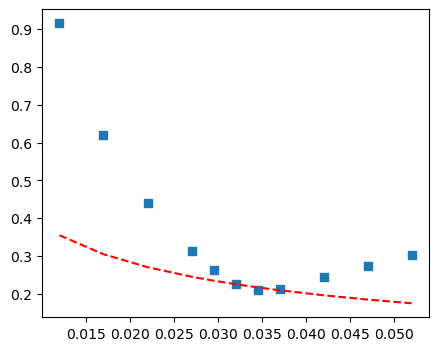

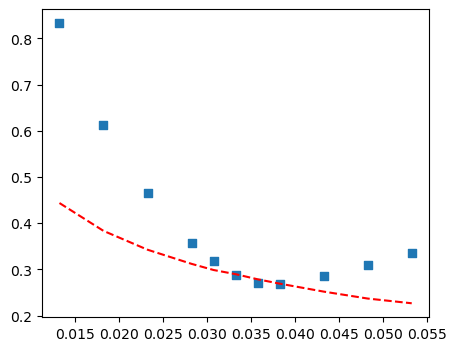

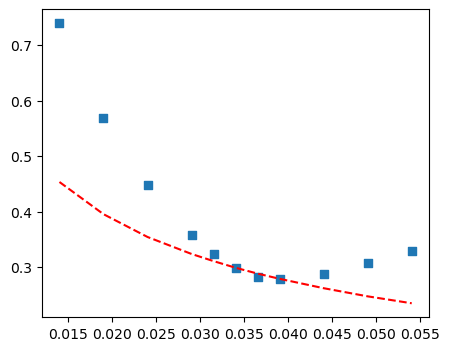

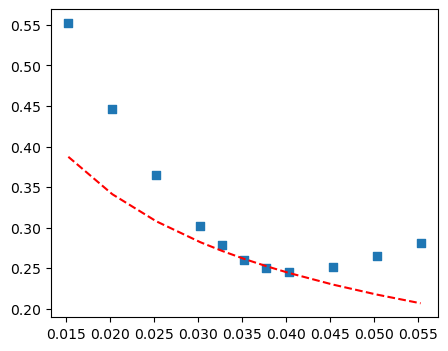

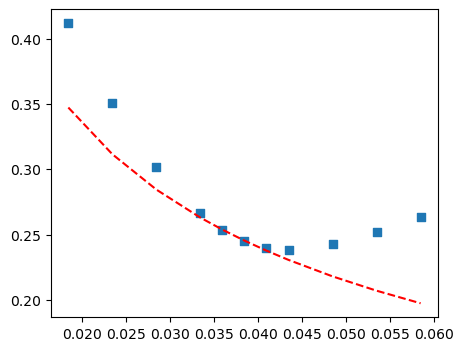

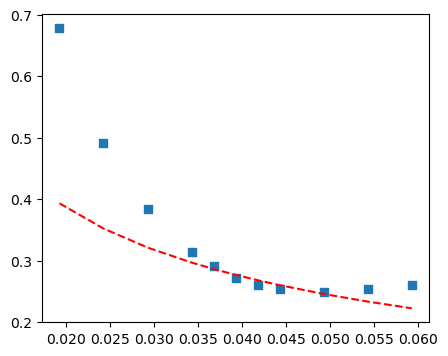

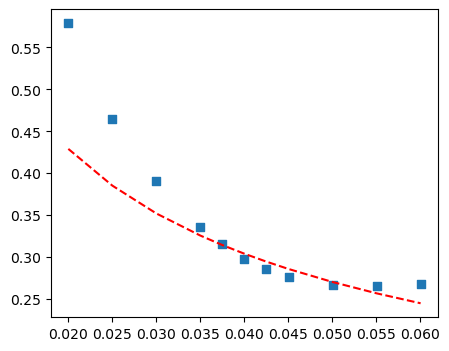

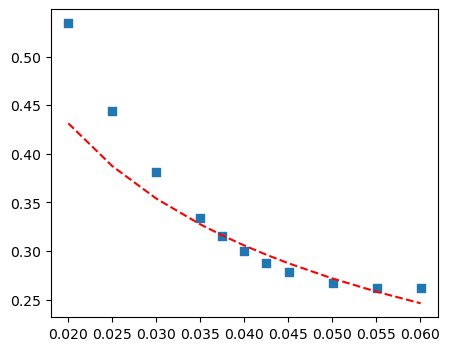

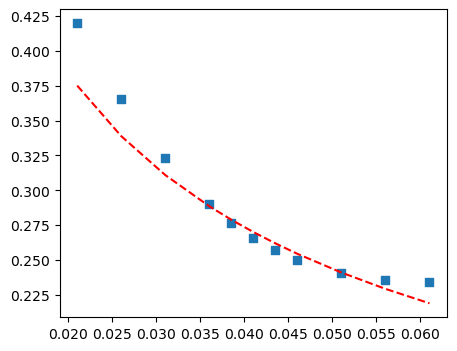

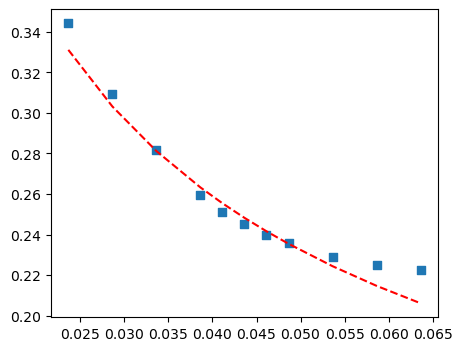

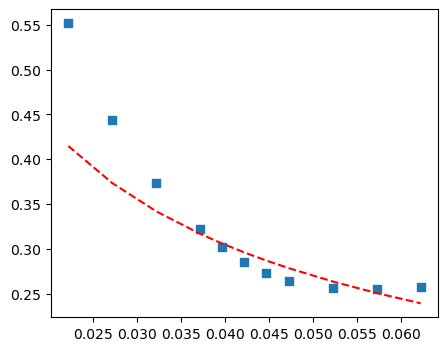

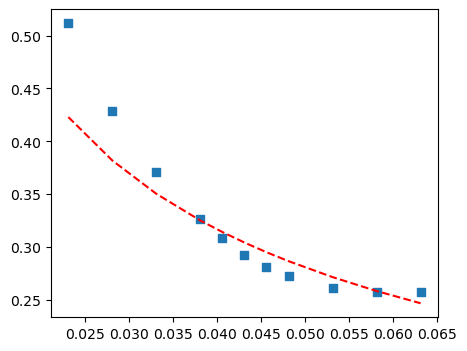

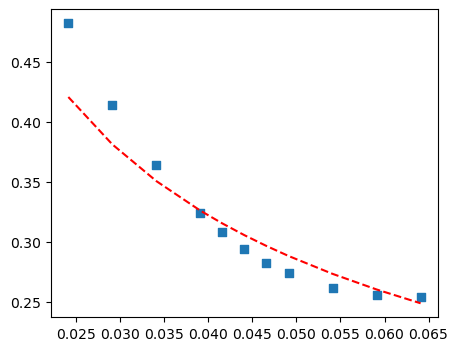

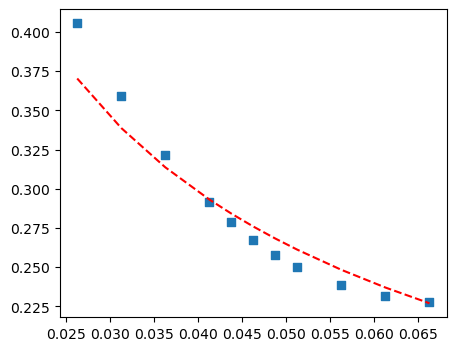

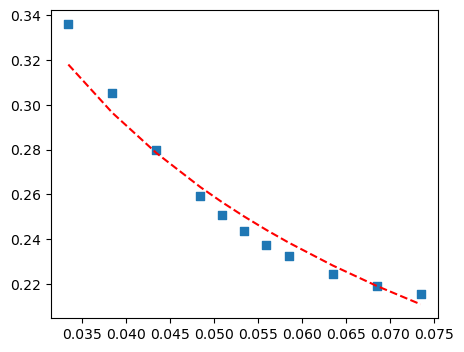

In [39]:
# plot the calibrated DD model with the market vols 
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_Discount[2*ex_int:(ex_int+te_int)*2])
        T = ex_int
        
        DD_vols = [volatility(fwd, i, pvbp, T, DD_Cali_Sigma.loc[ex,te], DD_Cali_Beta.loc[ex, te]) 
                   for i in strikes]
        
        plt.figure(figsize = (5,4))
        plt.scatter(strikes, market_vols,marker = 's')
        plt.plot(strikes, DD_vols, '--r')

# SABR Calibration

In [40]:
beta = 0.9

##### \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}

In [41]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

In [42]:
SABR_Alpha=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Rho=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Nu=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [43]:
initialGuess_sabr=[0.15,-0.4,0.6]

In [44]:
for ex in Expiry:
    for te in Tenor:             #Set sigma,T,ATM,strikes
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
    
        T=int(ex[:-1])
       
        res=least_squares(lambda x: sabrcalibration(x,
                                           strikes,
                                           market_vol,
                                           fwd,
                                           T),
                          initialGuess_sabr,
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
        SABR_Alpha[te][ex]=res.x[0]
        SABR_Rho[te][ex]=res.x[1]
        SABR_Nu[te][ex]=res.x[2]

In [45]:
SABR_Alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.139061,0.184649,0.196849,0.178051,0.171073
5Y,0.166499,0.199385,0.209731,0.188195,0.172197
10Y,0.177136,0.193791,0.204197,0.192592,0.167843


In [46]:
SABR_Rho

,1Y,2Y,3Y,5Y,10Y
1Y,-0.633280,-0.525117,-0.482843,-0.414413,-0.264900
5Y,-0.584968,-0.546346,-0.547256,-0.493732,-0.392101
10Y,-0.544353,-0.539995,-0.542701,-0.534139,-0.443578


In [47]:
SABR_Nu

,1Y,2Y,3Y,5Y,10Y
1Y,2.049672,1.677407,1.438152,1.064907,0.778199
5Y,1.339284,1.061521,0.936034,0.680061,0.530337
10Y,1.005600,0.921104,0.862169,0.713666,0.599924


In [48]:
def sabrvol(F, K, pvbp, T, alpha, beta, rho, nu):
    
    sigma = SABR(F, K, T, alpha, beta, rho, nu)
    if F <= K:
        price = Black76Call(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = Black76Put(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0.5)
    return vol[0]

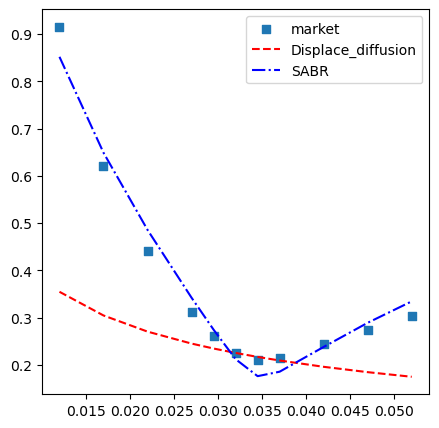

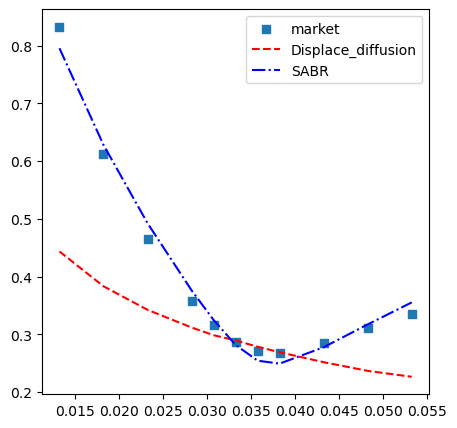

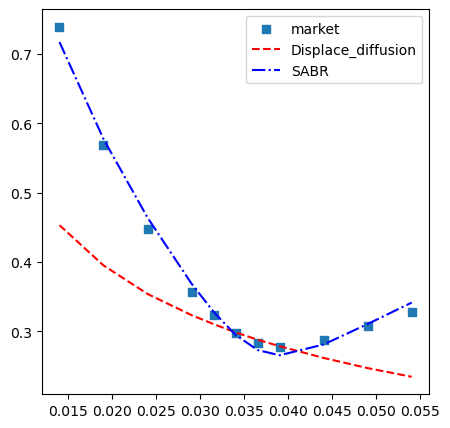

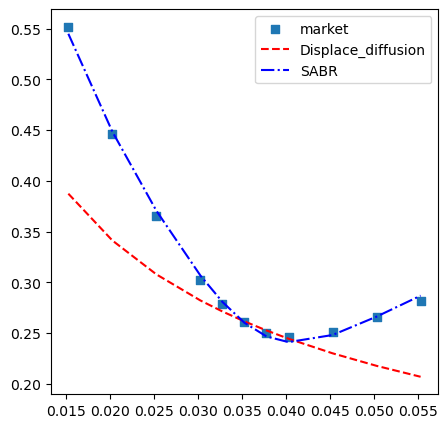

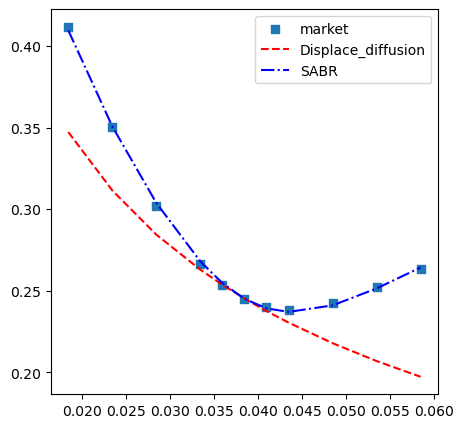

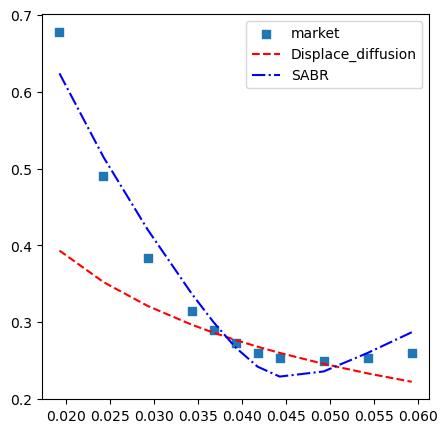

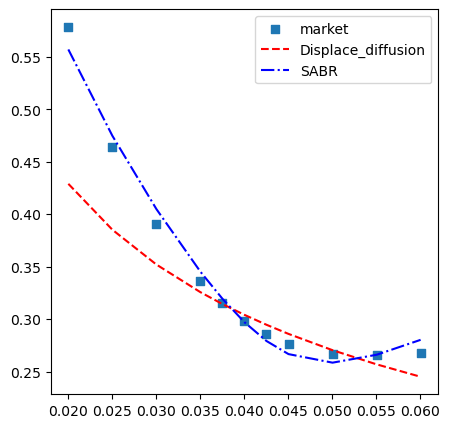

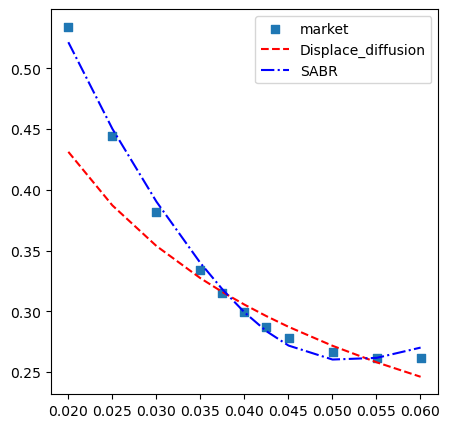

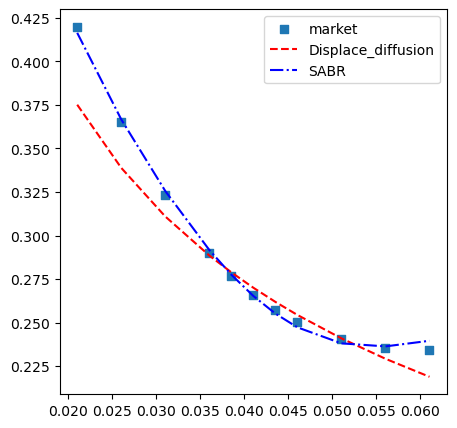

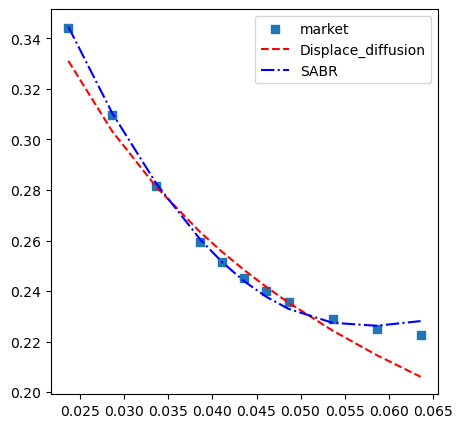

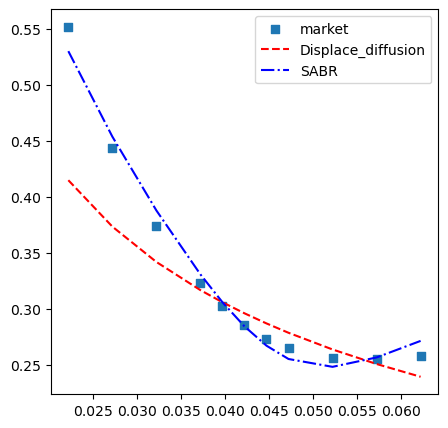

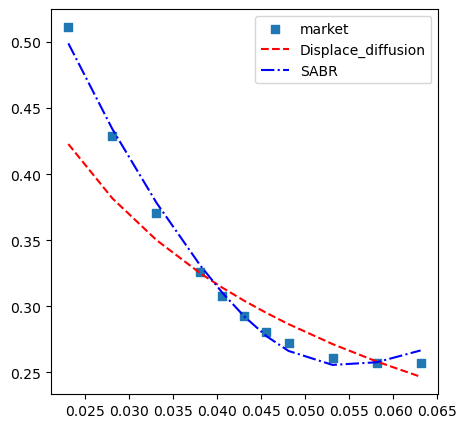

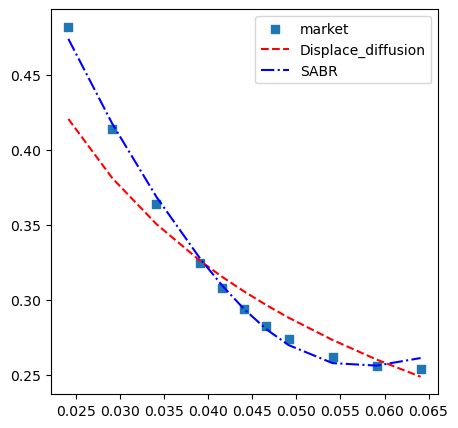

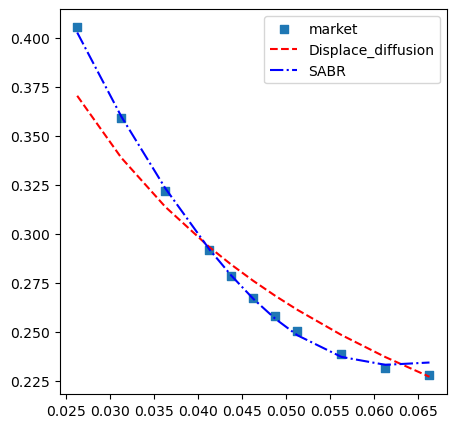

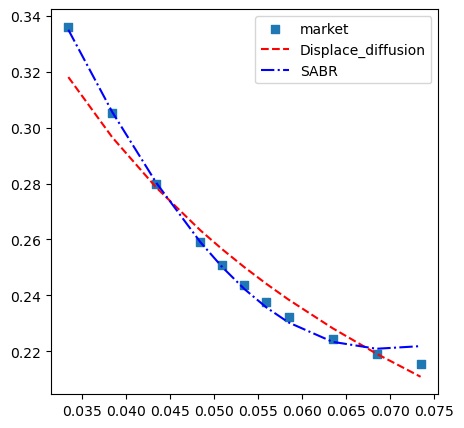

In [63]:
# plot the DD model and SABR model
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex
                                
                                , te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(semi_annual_DF.OIS_Discount[2*ex_int:(ex_int+te_int)*2])
        T = ex_int
        
        DD_vols = [volatility(fwd, i, pvbp, T, DD_Cali_Sigma.loc[ex,te], DD_Cali_Beta.loc[ex, te]) 
                   for i in strikes]
        SABR_vols = [sabrvol(fwd, i, pvbp, T, SABR_Alpha.loc[ex,te], 0.9,
                             SABR_Rho.loc[ex, te], SABR_Nu.loc[ex, te]) for i in strikes]
        
        plt.figure(figsize = (5,5 ))
        plt.scatter(strikes, market_vols,marker = 's', label= 'market')
        plt.plot(strikes, DD_vols, '--r', label = 'Displace_diffusion')
        plt.plot(strikes, SABR_vols, '-.b', label = 'SABR')
        plt.legend()

In [50]:
SABR_Alpha.to_csv('sabr_alpha.csv')
SABR_Rho.to_csv('sabr_rho.csv')
SABR_Nu.to_csv('sabr_nu.csv')

# Pricing The Swaptions Using The DD and SABR Models

In [51]:
# def interpolation equations
def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

In [52]:
sigma = interpol(1,DD_Cali_Sigma['10Y']['1Y'],5,DD_Cali_Sigma['10Y']['5Y'],2)
beta = interpol(1,DD_Cali_Beta['10Y']['1Y'],5,DD_Cali_Beta['10Y']['5Y'],2)

In [53]:
fwd1 = 0.03963437677316925
strikes=np.arange(0.01,0.081,0.01)
T = 2
pvbp1 = 0.5 * sum(semi_annual_DF.OIS_Discount[2*2:(2+10)*2])

In [54]:
alpha=interpol(1,SABR_Alpha['10Y']['1Y'],5,SABR_Alpha['10Y']['5Y'],2)
rho=interpol(1,SABR_Rho['10Y']['1Y'],5,SABR_Rho['10Y']['5Y'],2)
nu=interpol(1,SABR_Nu['10Y']['1Y'],5,SABR_Nu['10Y']['5Y'],2)

In [55]:
payer_DD = [DD_Call(fwd1, i, sigma, pvbp1, beta, T) for i in strikes]  

In [56]:
payer_SABR=[Black76Call(fwd1,i,SABR(fwd1,i,T,alpha,0.9,rho,nu),pvbp1, T) for i in strikes]

In [57]:
payer = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_DD,
                     'SABR': payer_SABR})
payer

,Strikes,Displaced Diffusion,SABR
0,0.01,0.288142,0.289641
1,0.02,0.194936,0.198314
2,0.03,0.112326,0.115059
3,0.04,0.051345,0.051953
4,0.05,0.017366,0.021432
5,0.06,0.004106,0.010950
6,0.07,0.000651,0.006858
7,0.08,0.000067,0.004869


In [58]:
# for receiver 8x10y
fwd2 = 0.04871114894211796
pvbp2 = 0.5 * sum(semi_annual_DF.OIS_Discount[8*2:(8+10)*2])
T = 8

In [59]:
sigma = interpol(5,DD_Cali_Sigma['10Y']['5Y'],10,DD_Cali_Sigma['10Y']['10Y'],8)
beta = interpol(5,DD_Cali_Beta['10Y']['5Y'],10,DD_Cali_Beta['10Y']['10Y'],8)

In [60]:
alpha=interpol(5,SABR_Alpha['10Y']['5Y'],10,SABR_Alpha['10Y']['10Y'],8)
rho=interpol(5,SABR_Rho['10Y']['5Y'],10,SABR_Rho['10Y']['10Y'],8)
nu=interpol(5,SABR_Nu['10Y']['5Y'],10,SABR_Nu['10Y']['10Y'],8)

In [61]:
rec_DD = [DD_Put(fwd2, i, sigma, pvbp2, beta, T) for i in strikes]
rec_SABR=[Black76Put(fwd2, i, SABR(fwd2,i,T,alpha,0.9,rho,nu), pvbp2, T) for i in strikes]

In [62]:
receiver = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':rec_DD,
                     'SABR': rec_SABR})
receiver

,Strikes,Displaced Diffusion,SABR
0,0.01,0.018985,0.020581
1,0.02,0.033904,0.039522
2,0.03,0.056649,0.061266
3,0.04,0.088980,0.089192
4,0.05,0.132050,0.128910
5,0.06,0.186136,0.186329
6,0.07,0.250582,0.259981
7,0.08,0.323971,0.342977
